In [1]:
from tests.auth_utils import get_toolkit_client

In [2]:
import time
from dataclasses import dataclass

from cognite.client.data_classes import FileMetadataList, FileMetadataWrite
from cognite.client.data_classes.data_modeling import NodeId, SpaceApply
from cognite.client.data_classes.data_modeling.cdm.v1 import CogniteFileApply

from cognite_toolkit._cdf_tk.client.data_classes.pending_instances_ids import PendingInstanceId

In [3]:
client = get_toolkit_client("dev-cluster.env", enable_set_pending_ids=True)

Found dev-cluster.env file in repository root. Loaded variables from dev-cluster.env file.


In [4]:
N = [1, 10, 100, 1_000, 10_000, 30_000]  # , 100_000, 300_000]

In [5]:
@dataclass
class Execution:
    n: int
    create_file: float | None = None
    set_pending_ids: float | None = None
    create_cognite_file: float | None = None
    updated_file: float | None = None

In [6]:
# Reset for running multiple times
delete_count = 0
for existing in client.files(external_id_prefix="file_qa_load_testing", chunk_size=1000):
    delete_count += len(existing)
    instance_ids = [ts.instance_id for ts in existing if ts.instance_id is not None]
    if instance_ids:
        client.data_modeling.instances.delete_fast(instance_ids)
    ids = [ts.id for ts in existing if ts.instance_id is None]
    if ids:
        client.files.delete(id=ids)
    print(f"\rProgress: {delete_count:,}", end="", flush=True)
print(f"\nDeleted {delete_count:,} existing files with prefix 'file_qa_load_testing'", end="", flush=True)

Progress: 11,111
Deleted 11,111 existing files with prefix 'file_qa_load_testing'

In [ ]:
execution_times: list[Execution] = []
for n in N:
    execution = Execution(n=n)
    space = f"sp_upgrade_{n}"
    files = [
        FileMetadataWrite(
            external_id=f"file_qa_load_testing_{n}_{i}",
            name=f"QA Load Testing {n} {i}",
        )
        for i in range(n)
    ]

    t0 = time.perf_counter()
    created = FileMetadataList([])
    for no, file in enumerate(files, 1):
        created_file = client.files.upload_bytes(b"Dummy content", **file.dump(camel_case=False))
        created.append(created_file)
        if no % 100 == 0:
            print(f"\rCreated {no} files for n={n}", end="", flush=True)
    elapsed = time.perf_counter() - t0
    execution.create_file = elapsed
    print(f"\nCreated {len(created)} file for n={n} in {elapsed:.2f} seconds")
    client.data_modeling.spaces.apply(SpaceApply(space))

    t0 = time.perf_counter()
    set_pending = client.files.set_pending_ids(
        [PendingInstanceId(NodeId(space, file.external_id), external_id=file.external_id) for file in files]
    )
    elapsed = time.perf_counter() - t0
    execution.set_pending_ids = elapsed
    print(f"Set pending ids for {len(set_pending)} time series for n={n} in {elapsed:.2f} seconds")

    cognite_file = [
        CogniteFileApply(
            space=space,
            external_id=file.external_id,
            name=file.name,
        )
        for file in files
    ]
    t0 = time.perf_counter()
    created_dm = client.data_modeling.instances.apply_fast(cognite_file)
    elapsed = time.perf_counter() - t0
    execution.create_cognite_file = elapsed

    print(f"Created {len(created_dm)} CogniteFiles for n={n} in {elapsed:.2f} seconds")

    updated_count = 0
    t0 = time.perf_counter()
    not_updated = created.as_ids()
    while updated_count < len(created):
        updated = client.files.retrieve_multiple(not_updated)
        not_updated = [ts.id for ts in updated if ts.instance_id is None]
        updated_count = len(created) - len(not_updated)
        print(f"\rUpdated {updated_count} files for n={n}", end="", flush=True)
        if not not_updated:
            break
        time.sleep(0.5)
    elapsed = time.perf_counter() - t0
    execution.updated_file = elapsed
    print(f"\nTotal time for n={n}: {elapsed:.2f} seconds")
    execution_times.append(execution)
    print("--" * 20)


Created 1 file for n=1 in 0.16 seconds
Set pending ids for 1 time series for n=1 in 0.07 seconds
Created 1 CogniteFiles for n=1 in 0.14 seconds
Updated 1 files for n=1
Total time for n=1: 128.38 seconds
----------------------------------------

Created 10 file for n=10 in 1.19 seconds
Set pending ids for 10 time series for n=10 in 0.10 seconds
Created 10 CogniteFiles for n=10 in 0.21 seconds
Updated 10 files for n=10
Total time for n=10: 0.61 seconds
----------------------------------------
Created 100 files for n=100
Created 100 file for n=100 in 10.91 seconds
Set pending ids for 100 time series for n=100 in 0.31 seconds
Created 100 CogniteFiles for n=100 in 0.41 seconds
Updated 100 files for n=100
Total time for n=100: 0.66 seconds
----------------------------------------
Created 1000 files for n=1000
Created 1000 file for n=1000 in 100.26 seconds
Set pending ids for 1000 time series for n=1000 in 2.82 seconds
Created 1000 CogniteFiles for n=1000 in 2.26 seconds
Updated 1000 files f

In [8]:
import matplotlib.pyplot as plt

In [9]:
x = [e.n for e in execution_times]
y0 = [e.create_file for e in execution_times]
y1 = [e.updated_file for e in execution_times]
y2 = [e.set_pending_ids for e in execution_times]
y3 = [e.create_cognite_file for e in execution_times]

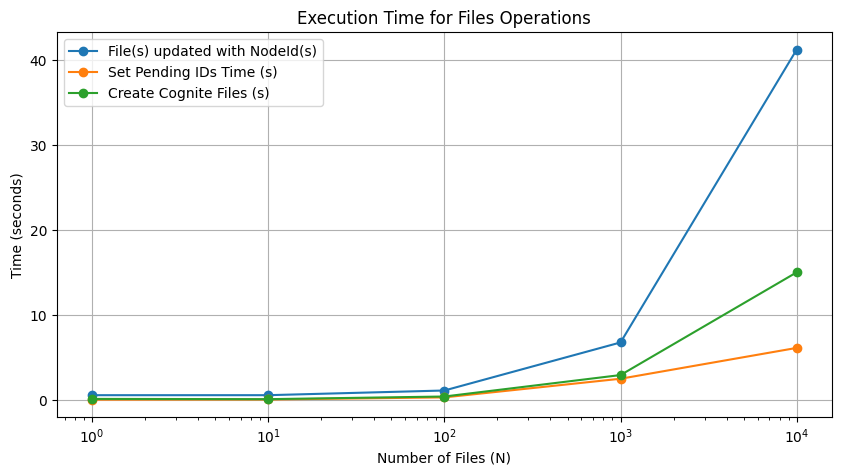

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(x, y1, marker="o", label="File(s) updated with NodeId(s)")
plt.plot(x, y2, marker="o", label="Set Pending IDs Time (s)")
plt.plot(x, y3, marker="o", label="Create Cognite Files (s)")
# plt.plot(x, y0, marker="o", label="Create Files (s)")
plt.xscale("log")
plt.xlabel("Number of Files (N)")
plt.ylabel("Time (seconds)")
plt.title("Execution Time for Files Operations")
plt.xticks(x)
plt.grid(True)
plt.legend();

In [11]:
from dataclasses import asdict

In [12]:
import pandas as pd

In [13]:
df = pd.DataFrame([asdict(e) for e in execution_times])

In [14]:
df.to_csv("qa_load_testing_results_files.csv", index=False)